# Bremsstrahlung Relativistic Radiation


By: Pablo Sotomayor 

---

Bremsstrahlung or deceleration radiation (form German bremsen ”to brake” and Strahlung ”radiation”) is important radiation mechanism in laboratory and astrophysical plasmas. Bremsstrahlung radiation is produced when a relativistic charged particle is accelerated in an electrostatic field. Since protons are generally less motile than electrons, bremsstrahlung or free-free emission is often considered as a radiative process of decelerating electron in the Coulomb field of an ion.

Similar to the case of a population of electrons with a Maxwellian velocity distribution, non-thermal distributions lead to a continuous radiative spectrum. This notebook will provide insights into calculating cooling timescales, cross section, and emissivity by Bremsstrahlung radiation for relativistic particles.

In [1]:
# Getting libraries

import numpy as np
from scipy.integrate import simps
from math import pi, isclose, exp, log, log10
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Physical parameters
# Units: cgs

lightVelocity = 29979245800
thomsonCrossSection = 6.6524e-25
fineStructureConstant = 7.297352568e-3
electronMass = 9.1094e-28
protonMass = 1.6726e-24
elementalCharge = 4.8032e-10
erg2ev = 6.242e11
ev2erg = 1/erg2ev
solarMass = 1.989e33
solarRadius = 6.96e10
gravitationalConstant = 6.6743e-8
planckConstant = 6.6261e-27
boltzmannConstant = 1.3807e-16
barn2cm = 1e-24
cm2barn = 1./barn2cm
pc2cm = 3.086e18
lightday2pc = lightVelocity*24*3600/pc2cm
yr2sec = 3.156e7
solarLuminosity = 3.839e33
astronomicalUnit = 1.496e13
stefanBoltzmannConstant = 5.6704e-5
deg2rad = pi/180
rad2deg = 1/deg2rad

In [3]:
# Function that returns the physical parameters according to the type of particle

def mass(typeParticle):
    if typeParticle == 'electron':
        massParticle = electronMass
    elif typeParticle == 'proton':
        massParticle = protonMass    
    else:
        raise AttributeError('Unknown particle')
    return massParticle

def charge(typeParticle):
    chargeParticle = elementalCharge
    if typeParticle == 'neutron':
        return 0.
    return chargeParticle

def classicalRadius(typeParticle):
    q = charge(typeParticle)
    m = mass(typeParticle)
    c = lightVelocity
    return  q*q/m/c/c

def thomsonCrossSection(typeParticle):    
    return 8.*pi*(classicalRadius(typeParticle)**2)/3

def restEnergy(typeParticle):
    return mass(typeParticle)*c*c

## Differential cross section

Consider the production of a photon of energy $E_\gamma$ by a relativistic particle with energy $E$ that is scattered by a nucleus of charge $Ze$. The differential cross section for the interaction is:

$$\frac{{\rm d}\sigma_{\rm Br}}{{\rm d}E_{\gamma}}(E,E_{\gamma}) = \frac{4\alpha r_{\rm cl}^2 Z^2}{E_{\gamma}} \phi(E, E_{\gamma})$$

where $r_{\rm cl} = q^2/(mc^2)$ the classical radius of the particle, and $\alpha \simeq 1/137$ the fine structure constant. Function $\phi$ depends on the ionization state of the targets. For a fully ionized gas (e.g. HII regions):

$$\phi(E, E_{\gamma}) = \left[1 + \left(1 - \frac{E_{\gamma}}{E} \right)^2 - \frac{2}{3}\left(1 -  \frac{E_{\gamma}}{E}\right) \right]\left\{\ln \left[\frac{2E(E - E_{\gamma})}{mc^2 E_{\gamma}} \right] - \frac{1}{2}\right\} $$

while for a neutral or quasi-neutral gas (e.g. HI regions):

$$\phi(E, E_{\gamma}) = \left[1 + \left(1 - \frac{E_{\gamma}}{E} \right)^2 - \frac{2}{3}\left(1 -  \frac{E_{\gamma}}{E}\right) \right] \ln \left(\frac{191}{Z^{1/3}}\right) + \frac{1}{9}\left(1 - \frac{E_{\gamma}}{E} \right) $$

In [4]:
def diffCrossSection(
    lorentzFactor:float, 
    particle:str, 
    atomicNumber:int, 
    photonEnergy:float, 
    ionizationKey:str='ionized')->float:
    
    m = mass(particle)
    c = lightVelocity
    lf = lorentzFactor
    Ek = m*c*c*(lf - 1.)
    
    if photonEnergy > Ek or isclose(photonEnergy, Ek):        
        return 0
    
    Eg = photonEnergy
    Ep = lorentzFactor*m*c*c
    Z = atomicNumber
    
    x = 1 - Eg/Ep
    
    phi = 1 + x**2 - 2*x/3
    
    if ionizationKey=='ionized':
        phi *= (log(2*Ep*(Ep-Eg)/m/c/c/Eg) - 0.5)
    elif ionizationKey=='neutral':
        phi *= log(191./(Z**(1/3)))
        phi += x/9.
    else:
        raise AttributeError(f"{ionizationKey} is an unknown parameter")
    
    a = fineStructureConstant
    rcl = classicalRadius(particle)
    return 4*a*rcl*rcl*Z*Z*phi/Eg

**Example**: Plot the differential cross section for the bremsstrahlung radiation by a relativistic electron with energy $E=1\,{\rm TeV}$ slowed down by a) shielded nuclei (HI cloud), and b) naked nuclei (HII region). Consider emitted photons in the range of $10\,{\rm keV}$ up to $0.1\,{\rm TeV} $

In [5]:
particle = 'electron'
m = mass(particle)
c = lightVelocity
E = 1e12 *ev2erg
LF = E/m/c/c

Ephmin = 1e4* ev2erg
Ephmax = 0.1*E
arrEph = np.logspace(np.log10(Ephmin), np.log10(Ephmax), 100)

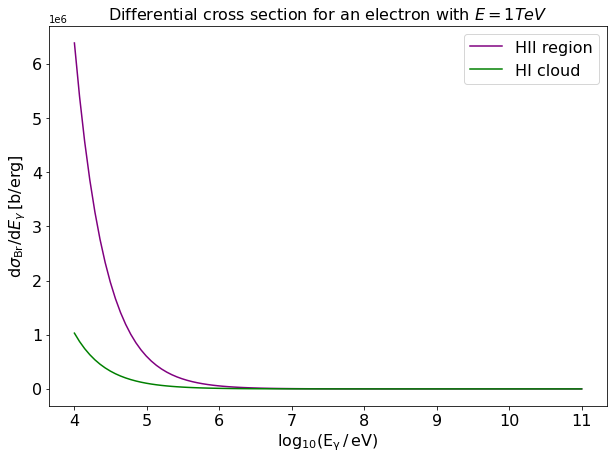

In [6]:
plt.figure(figsize=(10,7))

arrCS = np.empty_like(arrEph)

for i in range(len(arrCS)):
    arrCS[i] = diffCrossSection(lorentzFactor=LF, 
                                particle=particle, 
                                atomicNumber=1, 
                                photonEnergy=arrEph[i], 
                                ionizationKey='ionized')

plt.plot(np.log10(arrEph*erg2ev), arrCS*cm2barn, ls = "-", c='purple', label='HII region')

arrCS = np.empty_like(arrEph)

for i in range(len(arrCS)):
    arrCS[i] = diffCrossSection(lorentzFactor=LF, 
                                particle=particle, 
                                atomicNumber=1, 
                                photonEnergy=arrEph[i], 
                                ionizationKey='neutral')

plt.plot(np.log10(arrEph*erg2ev), arrCS*cm2barn, ls = "-", c='green', label='HI cloud')
    
plt.xlabel(r"$\log_{10} ({\rm E_{\gamma}\,/\,eV})$", fontsize=16)
plt.ylabel(r"${\rm d}\sigma_{\rm Br}/{\rm d}E_{\gamma}\,[{\rm b/erg}]$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(-0.5,1)
#plt.xlim(5,10.5)
plt.legend(fontsize=16)
plt.title(r'Differential cross section for an electron with $E = 1 TeV$', fontsize=16)
plt.show()

## Timescale of cooling by Bremsstrahlung radiation

Bremsstrahlung losses are essentially catastrophic: the particle loses almost all its energy in one interaction, and most of the emitted radiation is in the form of high-energy photons. We can, however, introduce an average continuous cooling rate. 

For an particle of energy $E$ in a plasma of fully ionized nuclei of charge $eZ$ and number density $n_{\rm p}$:

$$t_{\rm Br}^{-1} = 4\alpha_{\rm FS}r_{\rm cl}^2 Z^2 c n_{\rm p} \left[\log \left(\frac{2E}{mc^2}\right) - \frac{1}{3}  \right]$$

while for a neutral or quasi-neutral gas:

$$t_{\rm Br}^{-1} = 4\alpha_{\rm FS}r_{\rm cl}^2 Z^2 c n_{\rm p} \left[\log \left(\frac{183}{Z^{1/3}}\right) - \frac{1}{18}  \right]$$

In [7]:
def coolingTime(lorentzFactor:float, 
                particle:str, 
                atomicNumber:int, 
                numberDensity:float, 
                ionizationKey:str='ionized')->float:
    
    Z = atomicNumber
    rcl = classicalRadius(particle)
    m = mass(particle)
    c = lightVelocity
    E = lorentzFactor*m*c*c
    aFS = fineStructureConstant
    power = 4*aFS*E*(Z*rcl**2)*c*numberDensity
    
    if ionizationKey=='ionized':    
        power *= (np.log((2*lorentzFactor)) - 1/3)
    elif ionizationKey=='neutral':
        power *= (np.log(183/(Z**(1./3.))) - 1/18.)
    else:
        raise AttributeError(f"{ionizationKey} is an unknown parameter")
    return E/power

**Example**: Calculate the cooling timescale for electrons by relativistic Bremsstrahlung in a) HII region (density $n = 1\,{\rm cm^{-3}}$), and b) HI cloud (density $n = 100\,{\rm cm^{-3}}$). Consider a logarithmic step grid for the electron energies, with minimum energy $1\,{\rm MeV}$ and maximum energy $20\,{\rm GeV}$. Plot the results.

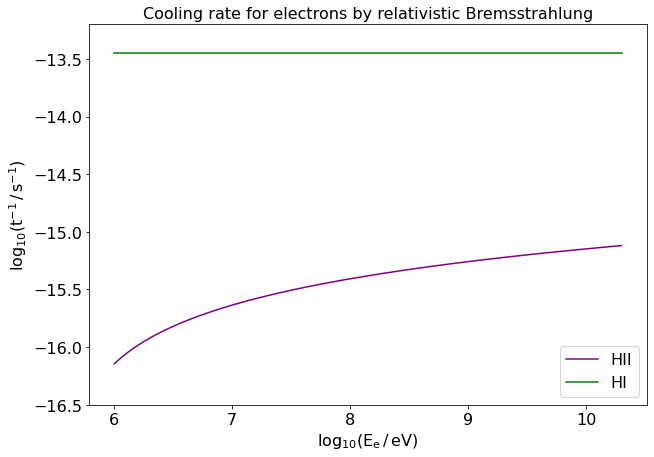

In [8]:
# Particle data

particle='electron'
m = mass(particle)
c = lightVelocity
Emin = 1e6 *ev2erg
Emax = 20 *1e9 *ev2erg

Egrid = 1000
arrE = np.logspace(np.log10(Emin), np.log10(Emax), Egrid)

plt.figure(figsize=(10,7))

# HII region

Z = 1
n = 1e0
arrTbr = np.empty_like(arrE)

for i in range(len(arrTbr)):
    arrTbr[i] = coolingTime(lorentzFactor=arrE[i]/m/c/c, 
                            particle='electron', 
                            atomicNumber=Z, 
                            numberDensity=n, 
                            ionizationKey='ionized')

plt.plot(np.log10(arrE*erg2ev), -np.log10(arrTbr),c='purple', label='HII')

# HI cloud

n = 1e2
arrTbr = np.empty_like(arrE)

for i in range(len(arrTbr)):
    arrTbr[i] = coolingTime(lorentzFactor=arrE[i]/m/c/c, 
                            particle='electron', 
                            atomicNumber=Z, 
                            numberDensity=n, 
                            ionizationKey='neutral')
    
plt.plot(np.log10(arrE*erg2ev), -np.log10(arrTbr),c='green', label='HI')

plt.xlabel(r"$\log_{10} ({\rm E_{e}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm t^{-1}\,/\,s^{-1}})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-16.5,-13.2)
plt.legend(fontsize=16)
plt.title("Cooling rate for electrons by relativistic Bremsstrahlung", fontsize=16)
plt.show()

## Power radiated by a single particle

The specific power emitted by a charged particle in an electrostatic field of a charge $Ze$ is given by:

$$P_{\rm Br}(E_{\gamma}, E) = E_{\gamma} n_{\rm p} c \frac{{\rm d}\sigma_{\rm Br}}{{\rm d}E_{\gamma}}(E_{\gamma}, E)\qquad [{\rm erg\,s^{-1}\,erg^{-1}}]$$

where its value depends on the shielding of the nuclei through which the particle decelerates.

In [9]:
def singleParticlePower(
    lorentzFactor:float, 
    particle:str, 
    atomicNumber:int, 
    numberDensity:float,
    photonEnergy:float,
    ionizationKey:str='ionized'):
    
    sigma = diffCrossSection(
        lorentzFactor=lorentzFactor, 
        particle=particle, 
        atomicNumber=atomicNumber,  
        photonEnergy=photonEnergy,
        ionizationKey=ionizationKey)    
    
    c = lightVelocity
    P = c*numberDensity*sigma*photonEnergy
    return P

**Example**: Calculate the specific power emitted for an electron with $E = 1\,{\rm TeV}$ by relativistic Bremsstrahlung in a) HII region (density $n = 1\,{\rm cm^{-3}}$), and b) HI cloud (density $n = 100\,{\rm cm^{-3}}$). Plot the results for photons in the energy range $10\,{\rm keV}$ up to $0.1\,{\rm TeV}$.

In [10]:
# Particle information

particle='electron'
m = mass(particle)
c = lightVelocity
Z = 1
E = 1e12 *ev2erg

# Array of photon energies

Ephmin = 1e4 * ev2erg
Ephmax = 0.1*E
EphGrid = 1000

arrEph = np.logspace(np.log10(Ephmin), np.log10(Ephmax), EphGrid)

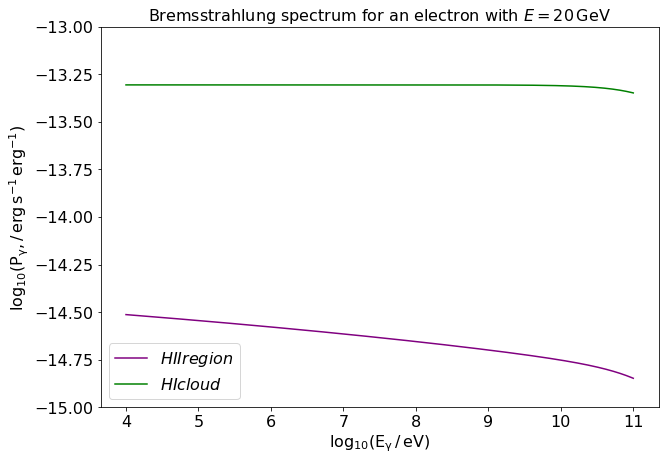

In [11]:
# Array of Bremsstrahlung power

Z = 1
arrPbr = np.empty_like(arrEph)

plt.figure(figsize=(10,7))

n = 1e0
for i in range(EphGrid):
    arrPbr[i] = singleParticlePower(
        lorentzFactor=E/m/c/c, 
        particle=particle, 
        atomicNumber=Z, 
        numberDensity=n,
        photonEnergy=arrEph[i], 
        ionizationKey='ionized')

plt.plot(np.log10(arrEph*erg2ev),np.log10(arrPbr), ls = "-", c='purple', label='$HII region$')

n = 1e2
for i in range(EphGrid):
    arrPbr[i] = singleParticlePower(
        lorentzFactor=E/m/c/c, 
        particle=particle, 
        atomicNumber=Z, 
        numberDensity=n,
        photonEnergy=arrEph[i], 
        ionizationKey='neutral')

plt.plot(np.log10(arrEph*erg2ev),np.log10(arrPbr), ls = "-", c='green', label='$HI cloud$')

plt.xlabel(r"$\log_{10} ({\rm E_{\gamma}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm P_{\gamma},/\,erg\,s^{-1}\,erg^{-1}})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.ylim(-15,-13)
plt.title(r'Bremsstrahlung spectrum for an electron with $E = 20\,{\rm GeV}$', fontsize=16)
plt.show()

## Power radiated by a distribution of non-thermal particles

The Bremsstrahlung power per unit volume for a population of particles with distribution function $N(E)$ is:

$$\epsilon_{\rm Br}(E_{\gamma}) = \int_{E_{\rm min}}^{E_{\rm max}}{\rm d}E\,N(E)P_{\rm Br}(E_{\gamma},E)\qquad [{\rm erg\,s^{-1}\,cm^{-3}\,erg^{-1}}]$$

where

$$[N(E)\,{\rm d}E] = {\rm cm^{-3}}$$

The Bremsstrahlung luminosity can be directly calculated in the one-zome model as:

$$L_{\rm Br}(E_{\gamma}) = V\times P_{\rm Br}(E_{\gamma})\qquad [{\rm erg\,s^{-1}\,erg^{-1}}]$$

where $V$ is the source volume. The bolometric luminosity of the source is given by:

$$L_{\rm bol} = \int_{E_{\gamma}^{\rm min}}^{E_{\gamma}^{\rm max}}{\rm d}E_{\gamma}\,L_{\rm Br}(E_{\gamma})$$

**Example**: An electron beam with energy density $1\,{\rm keV\,cm^{-3}}$ and differential intensity $I_{e} = K_{e}E^{-2.1} e^{-E/E_{\rm max}}$ is incident on a homogeneous cloud of neutral hydrogen of density $n_{\rm H}=200\,{\rm cm^{-3}}$ and radius $1\, {\rm pc}$. The minimum lorentz factor of the electrons is $\gamma_{\rm min}=2$ and the maximum $\gamma_{\rm max}=200$. Calculate the relativistic Bremsstrahlungo emission from this population of electrons. If the distance to the cloud is $20\,{\rm pc}$, what is the flux that would be detected at energies above $10\,{\rm MeV}$?

In [12]:
# Input parameters

particle = 'electron' 
p = 2.1                    # spectral index 
n = 2e2                    # number density of the cloud
r = pc2cm                  # cloud radius
volume = 4*pi*r*r*r/3      # cloud volume
LFmin = 2                  # minimum Lorentz factor
LFmax = 2e3                # maximum Lorentz factor
Ue = 1*1e3 *ev2erg         # energy density
Z = 1                      # atomic number
state = 'neutral'            # ionization state of the cloud

The relationship between the differential intensity and the electron distribution function is given by:

$$I_{e} = \frac{c}{4\pi}N(E) = K_{e}E^{-p} \exp{(-E/E_{\rm max})}$$

The parameter $K_{e}$ is calculated from the constraint of the total energy density in non-thermal particles:

$$u_{\rm E} = \int_{E_{\rm min}}^{E_{\rm max}}{\rm d}E\,E N(E)$$

Then

$$u_{\rm E} =\frac{4\pi}{c} \int_{E_{\rm min}}^{E_{\rm max}}{\rm d}E\,K_{e} E^{-p+1} \exp{(-E/E_{\rm max})}$$

In [13]:
# Array of particle energies

m = mass(particle)
c = lightVelocity
Egrid = 1000
arrE = np.logspace(np.log10(LFmin*m*c*c), np.log10(LFmax*m*c*c), Egrid)

In [14]:
# Calculating the distribution of relativistic electrons

integral = simps(arrE**(-p+1) * np.exp(-arrE/LFmax/m/c/c)) 
N0 = Ue/integral
arrN = N0*arrE**(-p)* np.exp(-arrE/LFmax/m/c/c)

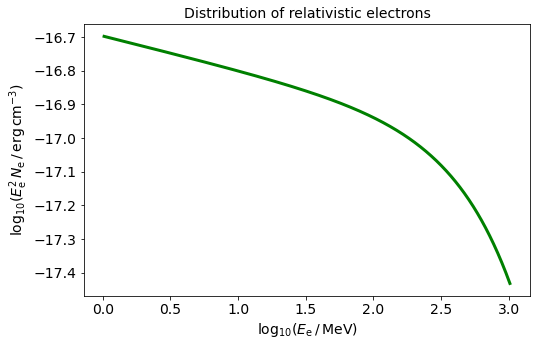

In [15]:
# Plotting the distribution

plt.figure(figsize=(8,5))
plt.plot(np.log10(arrE*erg2ev*1e-6), np.log10(arrE*arrE*arrN), lw=3, c="green")
plt.xlabel(r"$\log_{10} (E_{\rm e}\,/\,{\rm MeV})$", fontsize=14)
plt.ylabel(r"$\log_{10} (E_{\rm e}^{2}\,N_{\rm e}\,/\,{\rm erg\,cm^{-3}})$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Distribution of relativistic electrons", fontsize=14)
plt.show()

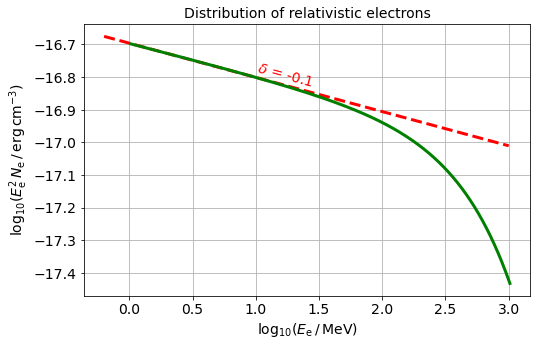

In [16]:
# Plotting the distribution and fitting

mask = (np.log10(arrE*erg2ev*1e-6) > 0) & (np.log10(arrE*erg2ev*1e-6) < 1.2)
z = np.polyfit(np.log10(arrE[mask]*erg2ev*1e-6), np.log10(arrE[mask]*arrE[mask]*arrN[mask]), 1)

x = np.linspace(-0.2,3,100)
y = z[1] + z[0]*x

plt.figure(figsize=(8,5))
plt.plot(x, y, ls="--", lw = 3, c="red")
plt.annotate(f"$\delta$ = {z[0]:0.2}", (1.0, -16.83), rotation=-15, fontsize=14, color='red')
plt.plot(np.log10(arrE*erg2ev*1e-6), np.log10(arrE*arrE*arrN), lw=3, c="green")
plt.xlabel(r"$\log_{10} (E_{\rm e}\,/\,{\rm MeV})$", fontsize=14)
plt.ylabel(r"$\log_{10} (E_{\rm e}^{2}\,N_{\rm e}\,/\,{\rm erg\,cm^{-3}})$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title("Distribution of relativistic electrons", fontsize=14)
plt.show()

The exponential cut-off softens the spectrum significantly at high energies.

In [17]:
# Auxiliary function that returns limits of intervals in which we divide the range of integration

def getSubArrays(arr:np.ndarray, 
                 tol=1e-6):    
    #---------------------------------------------------------------------
    # Getting the sub arrays
    # array 1: [Emin : 10Emin]
    # array 2: [10Emin : 100Emin]
    # ...
    # array N = [10^(N-1) Emin : 10^N Emin]
    # if 10^N Emin < Emax then one more array is added 
    #   interval N+1 = [10^N Emin : Emax]        
    #---------------------------------------------------------------------        
    xmin = arr[0]
    xmax = arr[-1]
    nArrays = int(np.log10(xmax/xmin))
    key = abs(xmax - xmin*10**nArrays) < tol*xmax 
    if not key:
        nArrays += 1
    #---------------------------------------------------------------------            
    # Setting the arrays of minimum and maximum energy
    # K sub arrays (K = N or K = N+1)
    # arrEmin = [Emin, 10Emin, 100Emin, ..., 10^(K-1)Emin]
    # arrEmax = [Emax, 10Emax, 100Emax, ..., min(10^K Emin, Emax)]
    #---------------------------------------------------------------------
    arrMin = np.ones(nArrays) 
    arrMax = np.ones(nArrays)
    for i in range(nArrays):
        arrMin[i] = xmin*10**(i)
        arrMax[i] = xmin*10**(i+1)    
    if not key:            
        arrMax[-1] = xmax
    return arrMin, arrMax 

In [18]:
nBremssEmi = 20

def getNodesGL(points):
    return np.polynomial.legendre.leggauss(points)  

In [19]:
def emissivity(arrParticleEnergy:np.ndarray, 
               arrParticleDensity:np.ndarray, 
               particle:str, 
               atomicNumber:int, 
               numberDensity:float, 
               photonEnergy:float, 
               ionizationKey:str='ionized'):             
        #---------------------------------------------------------------------            
        # Setting the arrays of minimum and maximum energy
        # K sub arrays  for the calculations
        # arrEmin = [Emin, 10Emin, 100Emin, ..., 10^(K-1)Emin]
        # arrEmax = [Emax, 10Emax, 100Emax, ..., Emax]
        #---------------------------------------------------------------------
        m =  mass(particle)
        Eg = photonEnergy
        Emin = m*c*c + Eg
        if Eg > arrParticleEnergy[-1] - c*c*m or isclose(Eg,arrParticleEnergy[-1] -  c*c*m):
            return 0        
        arrE, arrN = arrParticleEnergy, arrParticleDensity        
        arrN = np.delete(arrN, arrE <= Emin)
        arrE = np.delete(arrE, arrE <= Emin)    
        if len(arrE) == 0:
            return 0
        arrEmin, arrEmax = getSubArrays(arrE)                        
        #---------------------------------------------------------------------
        # Getting the specific emissivity
        # partialEmissivity[i] = Emissivity between arrEmin[i], arrEmax[i]
        #---------------------------------------------------------------------
        partialEmissivity = np.empty(len(arrEmin))      

        arrXgl, arrWgl = getNodesGL(nBremssEmi)
        for i in range(len(arrEmin)):
            #-----------------------------------------------------------------
            # arrE = [arrEmin[i]:arrEmax[i]]
            # arrN = N(arrE)
            # arrP = single particle power for arrE
            #-----------------------------------------------------------------
            arrE_ = 0.5*(arrEmax[i]-arrEmin[i])*arrXgl + 0.5*\
              (arrEmax[i]+arrEmin[i])
            arrN_ = np.interp(arrE_,arrE,arrN)
            arrLF_ = arrE_/m/c/c
            arrP_ = np.empty(nBremssEmi)            
            for k in range(nBremssEmi):
                arrP_ = singleParticlePower(lorentzFactor=arrLF_[k], 
                                            particle=particle, 
                                            atomicNumber=atomicNumber, 
                                            numberDensity=numberDensity, 
                                            photonEnergy=photonEnergy, 
                                            ionizationKey=ionizationKey)            
            partialEmissivity[i] = 0.5*(arrEmax[i]-arrEmin[i])*\
                sum(arrWgl*arrN_*arrP_)
        specificPower = sum(partialEmissivity)
        return specificPower/4/pi

In [20]:
Ephmin = 10**4.5 *ev2erg
Ephmax = (Emax - m*c*c)
EphGrid = Egrid
arrEph = np.logspace(np.log10(Ephmin), np.log10(Ephmax), EphGrid)
arrJbr = np.empty_like(arrEph)

In [21]:
for i, Eph in enumerate(arrEph):
    arrJbr[i] = emissivity(arrParticleEnergy=arrE, 
                           arrParticleDensity=arrN, 
                           particle=particle, 
                           atomicNumber=Z, 
                           numberDensity=n, 
                           photonEnergy=Eph, 
                           ionizationKey='neutral')

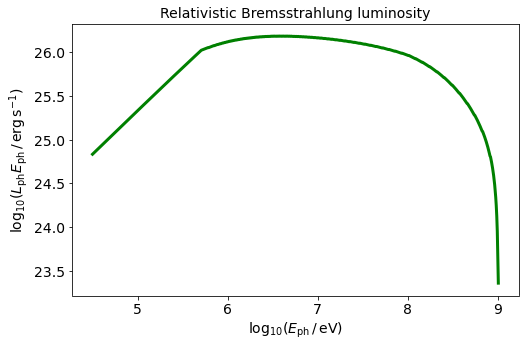

In [22]:
# Plotting the SED by relativistic Bremsstrahlung

plt.figure(figsize=(8,5))
plt.plot(np.log10(arrEph*erg2ev), np.log10(4*pi*arrEph*arrJbr*volume), ls = "-", lw=3, c='green', label='')
plt.xlabel(r"$\log_{10} (E_{\rm ph}\,/\,{\rm eV})$", fontsize=14)
plt.ylabel(r"$\log_{10} (L_{\rm ph}E_{\rm ph}\,/\,{\rm erg\,s^{-1}})$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Relativistic Bremsstrahlung luminosity", fontsize=14)
plt.show()

In [23]:
# First degree interpolating polynomial that fits the spectrum for the energies of interest

mask1 = (np.log10(arrEph*erg2ev) > 4.5) & (np.log10(arrEph*erg2ev) < 5.5)
z1 = np.polyfit(np.log10(arrEph[mask1]*erg2ev), np.log10(4*pi*arrEph[mask1]*arrJbr[mask1]*volume), 1)

mask2 = (np.log10(arrEph*erg2ev) > 6.7) & (np.log10(arrEph*erg2ev) < 7.5)
z2 = np.polyfit(np.log10(arrEph[mask2]*erg2ev), np.log10(4*pi*arrEph[mask2]*arrJbr[mask2]*volume), 1)

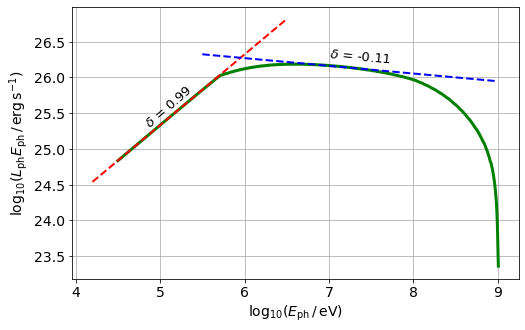

In [24]:
# Bremsstrahlung spectrum and Fitting

x = np.linspace(4.2,6.5,100)
y = z1[1] + z1[0]*x
plt.figure(figsize=(8,5))
plt.plot(np.log10(arrEph*erg2ev), np.log10(4*pi*arrEph*arrJbr*volume), ls = "-", lw=3, c='green', label='')
plt.plot(x, y, ls="--", lw = 2, c="red")
plt.annotate(f"$\delta$ = {z1[0]:0.2}", (4.8, 25.3), rotation=41, fontsize=13)

x2 = np.linspace(5.5,9,100)
y2 = z2[1] + z2[0]*x2
plt.plot(x2, y2, ls="--", lw = 2, c="blue")
plt.annotate(f"$\delta$ = {z2[0]:0.2}", (7.0, 26.2), rotation=-5, fontsize=13)

plt.xlabel(r"$\log_{10} (E_{\rm ph}\,/\,{\rm eV})$", fontsize=14)
plt.ylabel(r"$\log_{10} (L_{\rm ph}E_{\rm ph}\,/\,{\rm erg\,s^{-1}})$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

We calculate the total flux observed for photon energies $E>10\,{\rm MeV}$ for an observer at $d=20\,{\rm pc}$

In [25]:
# Observer data

d = 20*pc2cm
Egmin = 1e6 *ev2erg

arrFbr = 4*pi*arrJbr*volume/4/pi/d/d

In [27]:
x, y = arrEph, arrFbr
mask = arrEph > 1e7 *ev2erg
x, y = x[mask], y[mask]

integral = simps(y,x)
print(f"The total power emitted for photons with energies higher than 10 MeV is: {integral:0.2e} erg cm^-2 s^-1")

The total power emitted for photons with energies higher than 10 MeV is: 7.98e-15 erg cm^-2 s^-1


References:

- Introduction to Relativistic Astrophysics, Gustavo E. Romero (2018)
- PhD. Thesis, Gabriela S. Vila (2012)
- Introduction to Black Hole Astrophysics, Gustavo E. Romero & Gabriela S. Vila (2014)